In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re
from copy import deepcopy

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
filename = '../data/20250304_Hansenlab_chromatin_dynamics_all-data.h5'
data       = nl.io.load.hdf5(filename)['data']

In [3]:
data.makeSelection('minflux')
data_minflux_save = data.copySelection()

In [4]:
# To restore
data.makeSelection('minflux')
data.deleteSelection()
data_minflux_save.makeSelection()
data |= data_minflux_save

In [5]:
n_subsample = 4
def subsample(traj):
    out = nl.Trajectory(traj[::n_subsample])
    out.meta['Δt'] = n_subsample*traj.meta['Δt']
    return out

In [6]:
data.makeSelection('minflux')
data.apply(subsample, inplace=True)

# Fits

In [7]:
def chop(traj, dt=None, L=200, Fmin=2):
    if dt is None:
        dt = traj.meta['Δt']
    
    def chop_traj(traj, dt=dt):
        if 'Δt' in traj.meta:
            dt = traj.meta['Δt']
            
        chops = []
        i0 = 0
        while i0 < len(traj):
            i1 = i0+L
            chop = traj.data[:, i0:min(i1, len(traj)), :]
            try:
                t_start = np.nonzero(~np.any(np.isnan(chop), axis=(0, 2)))[0][0]
            except IndexError: # no valid entries in this chop
                new_traj = nl.Trajectory(chop[:, [0]])
            else:
                new_traj = nl.Trajectory(chop[:, t_start:])
                
            new_traj.meta['Δt'] = dt
            chops.append(new_traj)

            i0 = i1
            
        return chops
    
    chops = chop_traj(traj)
    out = nl.TaggedSet(chops, hasTags=False)
    while len(chops) > 1:
        cg_traj = nl.Trajectory(np.stack([traj.data[:, 0] for traj in chops], axis=1))
        cg_traj.meta['Δt'] = L*chops[0].meta['Δt']
        chops = chop_traj(cg_traj)
        for traj in chops:
            out.add(traj)
    
    # Clean out useless trajectories
    out.makeSelection(lambda traj, _: traj.F < Fmin)
    out.deleteSelection()
    return out

In [8]:
ct = 'U2OS'
bar = tqdm()

fits = {}
for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:

    cond = ', '.join(['H2B', ct, treatment])
    fits[treatment] = {
        'single' : {},
        'joints' : {},
    }

    # Minflux
    data.makeSelection(['minflux', cond], logic=all)
    dt = data[0].meta['Δt']

    fitdata = nl.TaggedSet()
    for traj in data:
        fitdata |= chop(traj.rescale(1e6, keepmeta=['Δt']))

    with nl.Parallelize():
        _ = nl.analysis.MSD(fitdata, chunksize=10, show_progress=True)

    fit = bayesmsd.lib.NPFit(fitdata, motion_blur_f=dt/n_subsample, parametrization='(log(αΓ), α)')
    fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
    fit.likelihood_chunksize = 200

    fits[treatment]['single'][f'minflux'] = fit

    bar.update()

    # Conventional
    for dt_tag in ['100ms', '2s']:
        data.makeSelection(['SPT', dt_tag, cond], logic=all)
        dt = data[0].meta['Δt']
        tau_e = 0.08671 # same exposure for both conditions

        fitdata = data.apply(lambda traj : traj.relative(keepmeta=['MSD', 'Δt']), inplace=False)

        fit = bayesmsd.lib.NPFit(fitdata, motion_blur_f=tau_e, parametrization='(log(αΓ), α)')
        fit.parameters['log(σ²) (dim 1)'].fix_to = 'log(σ²) (dim 0)'
        fit.likelihood_chunksize = 100

        fits[treatment]['single'][f'SPT-{dt_tag}'] = fit

        bar.update()

    # Assemble list of fit(group)s to run
    groups = {
        'minflux'       : ['minflux'],
        'SPT 100ms'     : ['SPT-100ms'],
        'SPT 2s'        : ['SPT-2s'],
        'SPT'           : ['SPT-100ms', 'SPT-2s'],
        'minflux + SPT' : ['minflux', 'SPT-100ms', 'SPT-2s'],
    }

    for groupname in groups:
        fits_dict = fits[treatment]['single']

        fit = bayesmsd.FitGroup({name : fits_dict[name] for name in groups[groupname]})
        fit.parameters['α']       = deepcopy(fits_dict['minflux'].parameters[      'α (dim 0)'])
        fit.parameters['log(αΓ)'] = deepcopy(fits_dict['minflux'].parameters['log(αΓ) (dim 0)'])

        # hacky...
        def patch_initial_params(self=fit):
            params = type(self).initial_params(self)
            a    = [val for key, val in params.items() if      'α' in key][0]
            logG = [val for key, val in params.items() if 'log(αΓ)' in key][0]
            params['α'] = a
            params['log(αΓ)'] = logG
            return params
        fit.initial_params = patch_initial_params

        for fitname in fit.fits_dict:
            fit.parameters[fitname+f' α (dim 0)'].fix_to = 'α'
            if fitname == 'minflux':
                fit.parameters[fitname+f' log(αΓ) (dim 0)'].fix_to = 'log(αΓ)'
            else: # not minflux, so correct for 2-loc
                def twoGref(params): return params['log(αΓ)']+np.log(2)
                fit.parameters[fitname+f' log(αΓ) (dim 0)'].fix_to = twoGref

        fits[treatment]['joints'][groupname] = fit

        bar.update()

bar.close()

0it [00:00, ?it/s]

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/6199 [00:00<?, ?it/s]

  0%|          | 0/7096 [00:00<?, ?it/s]

  0%|          | 0/6534 [00:00<?, ?it/s]

In [9]:
fitres = {}
for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:
    print()
    print(17*'=')
    print(f'|| {ct:>5s} {treatment:<5s} ||')
    print(17*'=')
    print()
    
    fitres[treatment] = {}
    for name in fits[treatment]['joints']:
        print(name)
        print('='*20)

        with nl.Parallelize():
            fitres[treatment][name] = fits[treatment]['joints'][name].run(show_progress=True)

        for key in fitres[treatment][name]['params']:
            print(key, fitres[treatment][name]['params'][key])
        print()


||  U2OS ctrl  ||

minflux


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.568080618413742
α 0.3290621973683439
log(αΓ) -5.6140300321076015
minflux α (dim 0) 0.3290621973683439
minflux log(αΓ) (dim 0) -5.6140300321076015

SPT 100ms


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.419809886386737
α 0.35189445537692055
log(αΓ) -5.7440698017163445
SPT-100ms α (dim 0) 0.35189445537692055
SPT-100ms log(αΓ) (dim 0) -5.050922621156399

SPT 2s


fit iterations: 0it [00:00, ?it/s]

SPT-2s log(σ²) (dim 0) -6.580923283903928
α 0.33457564292556724
log(αΓ) -5.943490576080706
SPT-2s α (dim 0) 0.33457564292556724
SPT-2s log(αΓ) (dim 0) -5.250343395520761

SPT


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.631419355609327
SPT-2s log(σ²) (dim 0) -8.406247819684586
α 0.29823379300245006
log(αΓ) -5.84288753018707
SPT-100ms α (dim 0) 0.29823379300245006
SPT-2s α (dim 0) 0.29823379300245006
SPT-100ms log(αΓ) (dim 0) -5.149740349627125
SPT-2s log(αΓ) (dim 0) -5.149740349627125

minflux + SPT


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.731302120803768
SPT-100ms log(σ²) (dim 0) -7.740276128371782
SPT-2s log(σ²) (dim 0) -12.946667856344217
α 0.2939633728941035
log(αΓ) -5.822654687382995
minflux α (dim 0) 0.2939633728941035
minflux log(αΓ) (dim 0) -5.822654687382995
SPT-100ms α (dim 0) 0.2939633728941035
SPT-2s α (dim 0) 0.2939633728941035
SPT-100ms log(αΓ) (dim 0) -5.12950750682305
SPT-2s log(αΓ) (dim 0) -5.12950750682305


||  U2OS DRB   ||

minflux


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.6304840804662
α 0.35185703844024085
log(αΓ) -5.353760882859745
minflux α (dim 0) 0.35185703844024085
minflux log(αΓ) (dim 0) -5.353760882859745

SPT 100ms


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.495122298255143
α 0.3151283341027713
log(αΓ) -5.490651399101109
SPT-100ms α (dim 0) 0.3151283341027713
SPT-100ms log(αΓ) (dim 0) -4.797504218541164

SPT 2s


fit iterations: 0it [00:00, ?it/s]

SPT-2s log(σ²) (dim 0) -6.137293453897925
α 0.3431881848348738
log(αΓ) -5.828673378017315
SPT-2s α (dim 0) 0.3431881848348738
SPT-2s log(αΓ) (dim 0) -5.13552619745737

SPT


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.638439689414303
SPT-2s log(σ²) (dim 0) -19.23026113045964
α 0.25744192082615935
log(αΓ) -5.649720156458092
SPT-100ms α (dim 0) 0.25744192082615935
SPT-2s α (dim 0) 0.25744192082615935
SPT-100ms log(αΓ) (dim 0) -4.956572975898147
SPT-2s log(αΓ) (dim 0) -4.956572975898147

minflux + SPT


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.882697308445117
SPT-100ms log(σ²) (dim 0) -7.2382632094399995
SPT-2s log(σ²) (dim 0) -18.313674196931604
α 0.30979368692239373
log(αΓ) -5.595878647648554
minflux α (dim 0) 0.30979368692239373
minflux log(αΓ) (dim 0) -5.595878647648554
SPT-100ms α (dim 0) 0.30979368692239373
SPT-2s α (dim 0) 0.30979368692239373
SPT-100ms log(αΓ) (dim 0) -4.902731467088609
SPT-2s log(αΓ) (dim 0) -4.902731467088609


||  U2OS TSA   ||

minflux


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.633831539474476
α 0.3160850856984596
log(αΓ) -5.678456700389107
minflux α (dim 0) 0.3160850856984596
minflux log(αΓ) (dim 0) -5.678456700389107

SPT 100ms


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.4652625292309835
α 0.31715434806107784
log(αΓ) -5.758675899757447
SPT-100ms α (dim 0) 0.31715434806107784
SPT-100ms log(αΓ) (dim 0) -5.065528719197502

SPT 2s


fit iterations: 0it [00:00, ?it/s]

SPT-2s log(σ²) (dim 0) -5.9463720030538365
α 0.40554444783250665
log(αΓ) -5.983107338105641
SPT-2s α (dim 0) 0.40554444783250665
SPT-2s log(αΓ) (dim 0) -5.289960157545695

SPT


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.485594096228442
SPT-2s log(σ²) (dim 0) -8.308355325803014
α 0.3057138017654273
log(αΓ) -5.78938867439177
SPT-100ms α (dim 0) 0.3057138017654273
SPT-2s α (dim 0) 0.3057138017654273
SPT-100ms log(αΓ) (dim 0) -5.096241493831824
SPT-2s log(αΓ) (dim 0) -5.096241493831824

minflux + SPT


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.712317682660343
SPT-100ms log(σ²) (dim 0) -7.578844757459832
SPT-2s log(σ²) (dim 0) -9.591049222307001
α 0.2996147015445656
log(αΓ) -5.7771214418805705
minflux α (dim 0) 0.2996147015445656
minflux log(αΓ) (dim 0) -5.7771214418805705
SPT-100ms α (dim 0) 0.2996147015445656
SPT-2s α (dim 0) 0.2996147015445656
SPT-100ms log(αΓ) (dim 0) -5.083974261320625
SPT-2s log(αΓ) (dim 0) -5.083974261320625


||  U2OS ICRF  ||

minflux


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.608466122005193
α 0.31025174706847924
log(αΓ) -5.7794295890575995
minflux α (dim 0) 0.31025174706847924
minflux log(αΓ) (dim 0) -5.7794295890575995

SPT 100ms


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.423759462961598
α 0.32864902354200753
log(αΓ) -6.044421011538409
SPT-100ms α (dim 0) 0.32864902354200753
SPT-100ms log(αΓ) (dim 0) -5.351273830978464

SPT 2s


fit iterations: 0it [00:00, ?it/s]

SPT-2s log(σ²) (dim 0) -6.799328583888659
α 0.32190774970591574
log(αΓ) -6.219392555155256
SPT-2s α (dim 0) 0.32190774970591574
SPT-2s log(αΓ) (dim 0) -5.526245374595311

SPT


fit iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) -7.556135134243421
SPT-2s log(σ²) (dim 0) -8.346976067072045
α 0.2862262373153821
log(αΓ) -6.121496914703187
SPT-100ms α (dim 0) 0.2862262373153821
SPT-2s α (dim 0) 0.2862262373153821
SPT-100ms log(αΓ) (dim 0) -5.428349734143241
SPT-2s log(αΓ) (dim 0) -5.428349734143241

minflux + SPT


fit iterations: 0it [00:00, ?it/s]

minflux log(σ²) (dim 0) -8.87807574687922
SPT-100ms log(σ²) (dim 0) -7.856396950533037
SPT-2s log(σ²) (dim 0) -17.493412855447602
α 0.25513873828257716
log(αΓ) -6.114631891813091
minflux α (dim 0) 0.25513873828257716
minflux log(αΓ) (dim 0) -6.114631891813091
SPT-100ms α (dim 0) 0.25513873828257716
SPT-2s α (dim 0) 0.25513873828257716
SPT-100ms log(αΓ) (dim 0) -5.421484711253146
SPT-2s log(αΓ) (dim 0) -5.421484711253146



In [10]:
nl.io.write.hdf5(fitres, f'20250327_no-kink_fitres_NPFit-aGparam_{ct}.h5')

## Profiler

In [ ]:
fitres = nl.io.load.hdf5(f'20250327_no-kink_fitres_NPFit-aGparam_{ct}.h5')
mci = {}
for treatment in ['ctrl', 'DRB', 'TSA', 'ICRF']:
    print()
    print(17*'=')
    print(f'|| {ct:>5s} {treatment:<5s} ||')
    print(17*'=')
    print()
    
    mci[treatment] = {}
    for name in fits[treatment]['joints']:
        print(name)
        print('='*20)
        
        profiler = bayesmsd.Profiler(fits[treatment]['joints'][name], max_restarts=50)
        profiler.point_estimate = fitres[treatment][name]

        with nl.Parallelize():
            mci[treatment][name] = profiler.find_MCI(show_progress=True)

        for key in mci[treatment][name]:
            m, (cil, cih) = mci[treatment][name][key]
            print(f"{key:>25s} = {m:>6.3f} [{cil:>6.3f}, {cih:>6.3f}]")
        print()


||  U2OS ctrl  ||

minflux


profiler iterations: 0it [00:00, ?it/s]

  minflux log(σ²) (dim 0) = -8.568 [-8.594, -8.542]
                        α =  0.329 [ 0.324,  0.334]
                  log(αΓ) = -5.614 [-5.643, -5.585]

SPT 100ms


profiler iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) = -7.420 [-7.479, -7.365]
                        α =  0.352 [ 0.340,  0.364]
                  log(αΓ) = -5.744 [-5.766, -5.722]

SPT 2s


profiler iterations: 0it [00:00, ?it/s]

   SPT-2s log(σ²) (dim 0) = -6.581 [-7.033, -6.293]
                        α =  0.335 [ 0.313,  0.356]
                  log(αΓ) = -5.943 [-5.984, -5.903]

SPT


profiler iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) = -7.631 [-7.680, -7.585]
   SPT-2s log(σ²) (dim 0) = -8.406 [-8.948, -8.052]
                        α =  0.298 [ 0.293,  0.304]
                  log(αΓ) = -5.843 [-5.850, -5.835]

minflux + SPT


profiler iterations: 0it [00:00, ?it/s]

[bayesmsd.Profiler @ 1]  Warning: Found a better point estimate (3508443.9000617154 > 3508443.8987627607)
[bayesmsd.Profiler @ 1]  Will restart from there (50 remaining)


fit iterations: 0it [00:00, ?it/s]

  minflux log(σ²) (dim 0) = -8.731 [-8.752, -8.711]
SPT-100ms log(σ²) (dim 0) = -7.740 [-7.770, -7.711]
   SPT-2s log(σ²) (dim 0) = -13.947 [  -inf, -9.328]
                        α =  0.294 [ 0.293,  0.295]
                  log(αΓ) = -5.823 [-5.829, -5.816]


||  U2OS DRB   ||

minflux


profiler iterations: 0it [00:00, ?it/s]

  minflux log(σ²) (dim 0) = -8.630 [-8.662, -8.601]
                        α =  0.352 [ 0.347,  0.357]
                  log(αΓ) = -5.354 [-5.385, -5.322]

SPT 100ms


profiler iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) = -7.495 [-7.588, -7.411]
                        α =  0.315 [ 0.303,  0.327]
                  log(αΓ) = -5.491 [-5.513, -5.468]

SPT 2s


profiler iterations: 0it [00:00, ?it/s]

   SPT-2s log(σ²) (dim 0) = -6.137 [-6.543, -5.872]
                        α =  0.343 [ 0.315,  0.371]
                  log(αΓ) = -5.829 [-5.880, -5.777]

SPT


profiler iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) = -7.638 [-7.713, -7.569]
   SPT-2s log(σ²) (dim 0) = -19.230 [  -inf, -11.527]
                        α =  0.257 [ 0.252,  0.263]
                  log(αΓ) = -5.650 [-5.659, -5.641]

minflux + SPT


profiler iterations: 0it [00:00, ?it/s]

[bayesmsd.Profiler @ 1]  Warning: Found a better point estimate (2961726.6248087487 > 2961726.6230789674)
[bayesmsd.Profiler @ 1]  Will restart from there (50 remaining)


fit iterations: 0it [00:00, ?it/s]

[bayesmsd.Profiler @ 4]  Warning: Found a better point estimate (2961726.626056942 > 2961726.6248108735)
[bayesmsd.Profiler @ 4]  Will restart from there (49 remaining)


fit iterations: 0it [00:00, ?it/s]

  minflux log(σ²) (dim 0) = -8.883 [-8.910, -8.856]
SPT-100ms log(σ²) (dim 0) = -7.238 [-7.262, -7.215]
   SPT-2s log(σ²) (dim 0) = -26.314 [  -inf, -11.435]
                        α =  0.310 [ 0.308,  0.311]
                  log(αΓ) = -5.596 [-5.603, -5.588]


||  U2OS TSA   ||

minflux


profiler iterations: 0it [00:00, ?it/s]

  minflux log(σ²) (dim 0) = -8.634 [-8.662, -8.605]
                        α =  0.316 [ 0.311,  0.321]
                  log(αΓ) = -5.678 [-5.708, -5.649]

SPT 100ms


profiler iterations: 0it [00:00, ?it/s]

SPT-100ms log(σ²) (dim 0) = -7.465 [-7.546, -7.391]
                        α =  0.317 [ 0.303,  0.331]
                  log(αΓ) = -5.759 [-5.784, -5.733]

SPT 2s


profiler iterations: 0it [00:00, ?it/s]

   SPT-2s log(σ²) (dim 0) = -5.946 [-6.085, -5.830]
                        α =  0.406 [ 0.384,  0.426]
                  log(αΓ) = -5.983 [-6.016, -5.947]

SPT


profiler iterations: 0it [00:00, ?it/s]

In [ ]:
nl.io.write.hdf5(mci, f'20250327_no-kink_mci_NPFit-aGparam_{ct}.h5')

## Archive: re-running individual fits

In [64]:
# Check SPT 2s: can we bound localization error?
fit = fits[ct]['joints']['minflux + SPT']

with nl.Parallelize():
    fit.parameters['conventional_100ms log(σ²) (dim 0)'].fix_to = -10
    fit.parameters['conventional_2s log(σ²) (dim 0)'].fix_to = -10
    res = fit.run(show_progress=True)
    fit.parameters['conventional_100ms log(σ²) (dim 0)'].fix_to = None
    fit.parameters['conventional_2s log(σ²) (dim 0)'].fix_to = None
    res = fit.run(show_progress=True, init_from=res)
res

/home/sgh/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sgh/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sgh/.local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


fit iterations: 0it [00:00, ?it/s]

fit iterations: 0it [00:00, ?it/s]

{'params': {'minflux_cgdt0 log(σ²) (dim 0)': -8.869284267941664,
  'conventional_100ms log(σ²) (dim 0)': -7.136720536120231,
  'conventional_2s log(σ²) (dim 0)': -17.006986347197845,
  'α': 0.26142995639362443,
  'log(Γ)': -4.919833444790012,
  'minflux_cgdt0 log(Γ) (dim 0)': -4.919833444790012,
  'minflux_cgdt0 α (dim 0)': 0.26142995639362443,
  'minflux_cgdt1 log(σ²) (dim 0)': -8.869284267941664,
  'minflux_cgdt1 log(Γ) (dim 0)': -4.919833444790012,
  'minflux_cgdt1 α (dim 0)': 0.26142995639362443,
  'minflux_cgdt2 log(σ²) (dim 0)': -8.869284267941664,
  'minflux_cgdt2 log(Γ) (dim 0)': -4.919833444790012,
  'minflux_cgdt2 α (dim 0)': 0.26142995639362443,
  'conventional_100ms α (dim 0)': 0.26142995639362443,
  'conventional_2s α (dim 0)': 0.26142995639362443,
  'conventional_100ms log(Γ) (dim 0)': -4.226686264230066,
  'conventional_2s log(Γ) (dim 0)': -4.226686264230066},
 'marginalized': {},
 'logL': 17401201.89600301}

In [65]:
fitres['minflux + SPT (vanilla)'] = fitres['minflux + SPT']
fitres['minflux + SPT'] = res

# Plotting

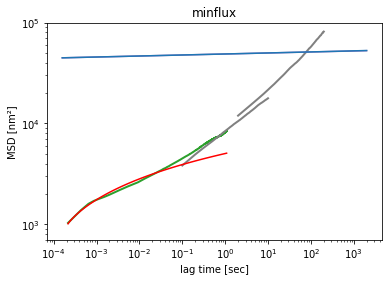

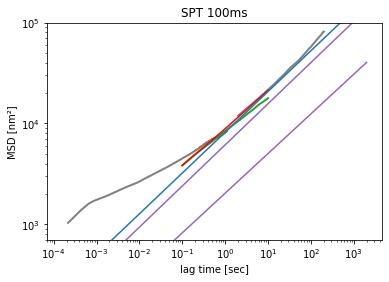

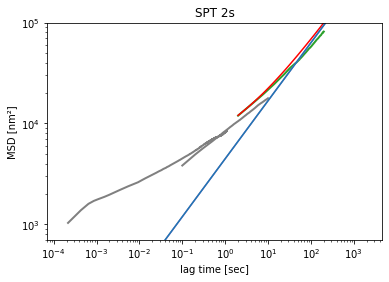

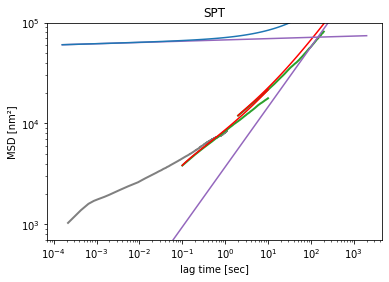

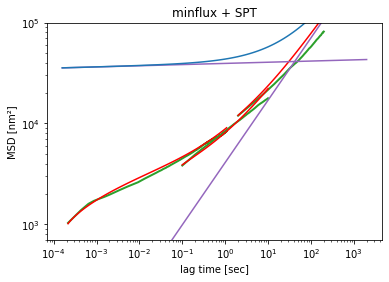

In [47]:
treatment = 'ICRF'

tmax = {
    'minflux'   : 5001,
    'SPT 100ms' : 101,
    'SPT 2s'    : 101,
    'Fbn2'      : 101,
}

data.makeSelection('minflux')
dts = {
    'minflux'   : data[0].meta['Δt'],
    'SPT 100ms' : 0.1,
    'SPT 2s'    : 2,
}

highlight_color = 'tab:green'
cond = ', '.join(['H2B', ct, treatment])

for resname in fitres[treatment]:
    fitnames = [name
                for name in fits[treatment]['single']
                if any([key.startswith(name) for key in fitres[treatment][resname]['params']])
               ]
    
    # minflux
    color = highlight_color if any(['minflux' in name for name in fitnames]) else 'gray'
    data.makeSelection(['minflux', cond], logic=all)
    dt = data[0].meta['Δt']

    msd = nl.analysis.MSD(data)
    msd *= 1e18 # nm²
    plt.plot(dt*np.arange(1, tmax['minflux']), msd[1:tmax['minflux']],
             color=color, linewidth=2,
            )

    # SPT
    for dt_tag in ['100ms', '2s']:
        color = highlight_color if 'SPT-'+dt_tag in fitnames else 'gray'
        
        data.makeSelection(['SPT', dt_tag, cond], logic=all)
        dt = data[0].meta['Δt']

        msd = nl.analysis.MSD(data)
        msd /= 2   # 2-loc
        msd *= 1e6 # nm²
        plt.plot(dt*np.arange(1, tmax['SPT '+dt_tag]), msd[1:tmax['SPT '+dt_tag]],
                 color=color, linewidth=2,
                )

    # fitres singles
    for fitname in fitnames:
        fit = fits[treatment]['single'][fitname]
        params = {key[(len(fitname)+1):] : val
                  for key, val in fitres[treatment][resname]['params'].items()
                  if key.startswith(fitname)
                 }
        params = fit.fill_dependent_params(params)
        
        key = 'minflux'
        if fitname.startswith('SPT'):
            dt_tag = fitname[len('SPT-'):]
            key = 'SPT '+dt_tag
        
        xplot = dts[key] * np.logspace(0, np.log10(tmax[key]), 100)
        msd = fit.MSD(params, dt=xplot)
        msd *= 1e6     # nm²
        if key != 'minflux':
            msd /= 2   # 2-loc
        
        plt.plot(xplot, msd,
                 color='r',
                )
    
    # fitres law
    a    = np.array([fitres[treatment][resname]['params'][f'α_{i}'] for i in range(n_powerlaws)])
    logG = np.array([fitres[treatment][resname]['params'][f'log(Γ_{i})'] for i in range(n_powerlaws)])

    G_1D = np.exp(logG)
    G_1D *= 1e6 # nm²

    xplot = np.logspace(-3.8, 3.3, 100)
    for i in range(n_powerlaws):
        plt.plot(xplot, 2*G_1D[i]*xplot**a[i], color='tab:purple')
    xplot = xplot[:, None] # ensure correct broadcasting with G, a
    plt.plot(xplot, np.sum(2*G_1D*xplot**a, axis=-1))

    # Plotting stuff
    plt.title(resname)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('lag time [sec]')
    plt.ylabel('MSD [nm²]')
    plt.ylim([7e2, 1e5])

    plt.show()